# Model comparison to GLODAP along GO-SHIP Easy Ocean lines
This notebook shows a means of comparing MOM6 ocean model data to GLODAP data along the WOCE/GO-SHIP sections. GLODAP data are taken from the cruises used to construct the Easy Ocean lines. Model data are interpolated onto the cruis station locations using `xesmf`. See [here](https://www.glodap.info/) for information on GLODAP, and [here](https://cchdo.ucsd.edu/products/goship-easyocean) for information on the Easy Ocean lines.

In [1]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean
import gsw
from geopy import distance
import xesmf as xe
import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/src')
import src
from src import *

In [2]:
plotsdir = lambda x="" : "../figures/" + x


In [3]:
def GLODAPP_LON_to_CM4X(lons):
    lons_copy = 1 * lons 
    lons_copy[lons_copy > 60] -= 360
    return lons_copy
def CM4X_LON_to_GLODAPP(lons): 
    lons_copy = 1 * lons 
    lons_copy[(lons_copy > -300) * (lons_copy < -180)] +=360
    return lons_copy

def CM4X_to_reg_grid(ds): 
    xhcopy = 1 * ds.xh.values
    xhcopy[(ds.xh > -300) * (ds.xh < -180)] += 360
    
    ds_copy = 1 * ds
    ds_copy.coords['xh'] = 1 * xhcopy

    return ds_copy.reindex({ "xh" : xhcopy})

def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='192GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=179G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.66:40282 --nthreads 36 --memory-limit 178.81GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [5]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'PuRd','units':'fmolkg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [6]:
def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":10, "longitude":10, "zl":-1, "year":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

ds = read_CM4X("../../CM4Xp25_historical_transient_tracers.zarr")
ds = ds.drop(["lat", "lon"])
ds = ds.rename({"geolat":"lat", "geolon":"lon"})
ds = ds.where(ds.thkcello > 1e-9)
# # 
#need to interpolate zl to z next 

In [7]:
ds_locs = xr.Dataset()
ds_locs["lon"] = xr.DataArray(
    data=np.arange(-299, 59), dims=("locations") #need to regrid within model coordinates
)
ds_locs["lat"] = xr.DataArray(data=np.repeat(-50, len(ds_locs["lon"])), dims=("locations"))

In [8]:
regridder = xe.Regridder(ds, ds_locs[["lon", "lat"]], "bilinear", locstream_out=True, periodic = False)
section_dsm = regridder(ds).compute()


In [9]:
section_dsm["lon"] = ("locations", ds_locs["lon"].values)
section_dsm["lat"] = ("locations", ds_locs["lat"].values)

In [10]:
section_dsm = get_sigma2(section_dsm).compute()

In [13]:
new_sigma_grid = np.linspace(section_dsm.sigma2.min(), section_dsm.sigma2.max())

In [15]:
ds_sections = []
for i in range(len(section_dsm.year)):
    if (i %20) == 0:
        print(i)
    tmp =  1* interpolate_section(section_dsm[["cfc11", "cfc12", "sf6", "sigma2", "thkcello", "z", "thetao"]].isel(year = i).compute(),
                                 new_sigma_grid, 
                                interp_coord = "sigma2",iterate_coord =  "locations", kind = "linear")
    ds_sections = ds_sections + [tmp]

ds_section = xr.concat(ds_sections, dim = "year")

0
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
20
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc12
sf6
thkcello
z
thetao
cfc11
cfc

[None, None, None]

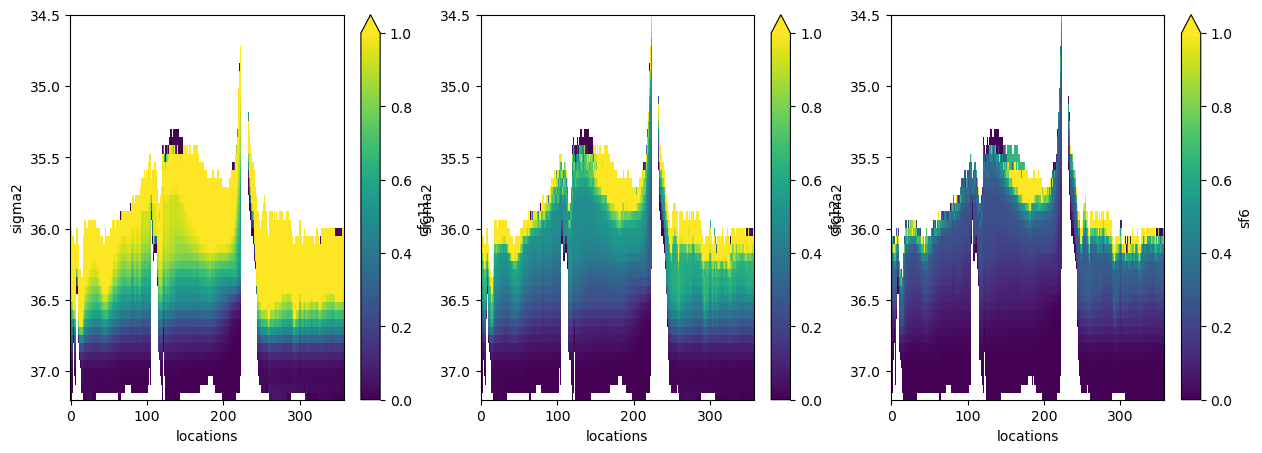

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))


(ds_section.cfc11.mean("year") * variable_kwargs["cfc11"]["conversion"]).plot(vmin = 0, vmax  = 1, ax = ax[0])
(ds_section.cfc12.mean("year") * variable_kwargs["cfc12"]["conversion"]).plot(vmin = 0, vmax  = 1, ax = ax[1])
(ds_section.sf6.mean("year") * variable_kwargs["sf6"]["conversion"]).plot(vmin = 0, vmax  =1, ax = ax[2])
[a.set_ylim(34.5, 37.2) for a in ax]
[a.invert_yaxis() for a in ax]


In [17]:
weighted_mean_ds = (ds_section * ds_section.thkcello).sum("locations") / ds_section.thkcello.sum("locations")

In [42]:
def derivative(ds):
    return ds.values[1:, :] - ds.values[:-1, :]

[None, None, None]

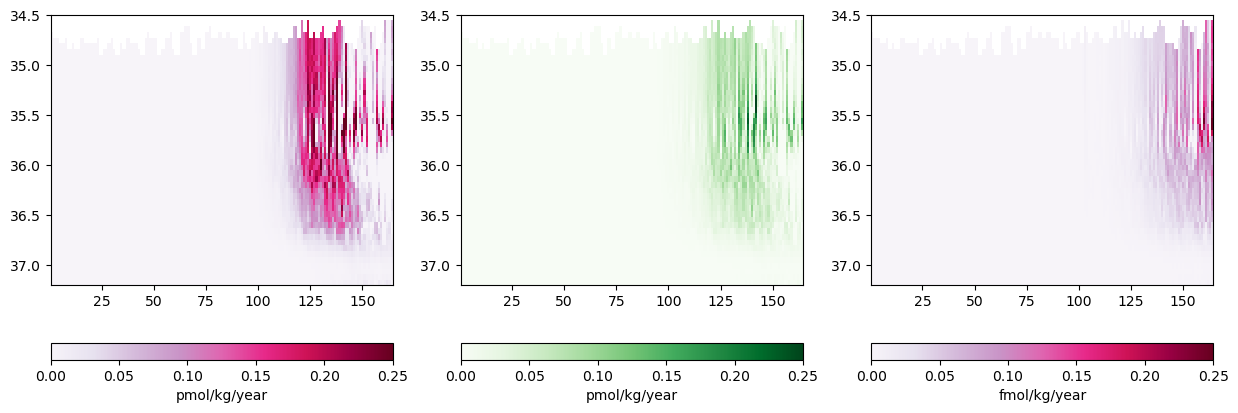

In [67]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

cm = ax[0].pcolormesh(weighted_mean_ds.year[1:], weighted_mean_ds.sigma2, derivative(weighted_mean_ds.cfc11).T * variable_kwargs["cfc11"]["conversion"], 
               cmap = variable_kwargs["cfc11"]["cmap"], vmin = 0, vmax = .25)
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", label = "pmol/kg/year")

cm = ax[1].pcolormesh(weighted_mean_ds.year[1:], weighted_mean_ds.sigma2, derivative(weighted_mean_ds.cfc12).T * variable_kwargs["cfc12"]["conversion"], 
               cmap = variable_kwargs["cfc12"]["cmap"], vmin = 0, vmax = .25)
fig.colorbar(cm, ax = ax[1], orientation = "horizontal", label = "pmol/kg/year")

cm = ax[2].pcolormesh(weighted_mean_ds.year[1:], weighted_mean_ds.sigma2, derivative(weighted_mean_ds.sf6).T * variable_kwargs["sf6"]["conversion"], 
               cmap = variable_kwargs["sf6"]["cmap"], vmin = 0, vmax = .25)
fig.colorbar(cm, ax = ax[2], orientation = "horizontal", label = "fmol/kg/year")


[a.set_ylim(34.5, 37.2) for a in ax]
# [a.set_xlim(1942, 2015) for a in ax]
[a.invert_yaxis() for a in ax]


[None, None, None]

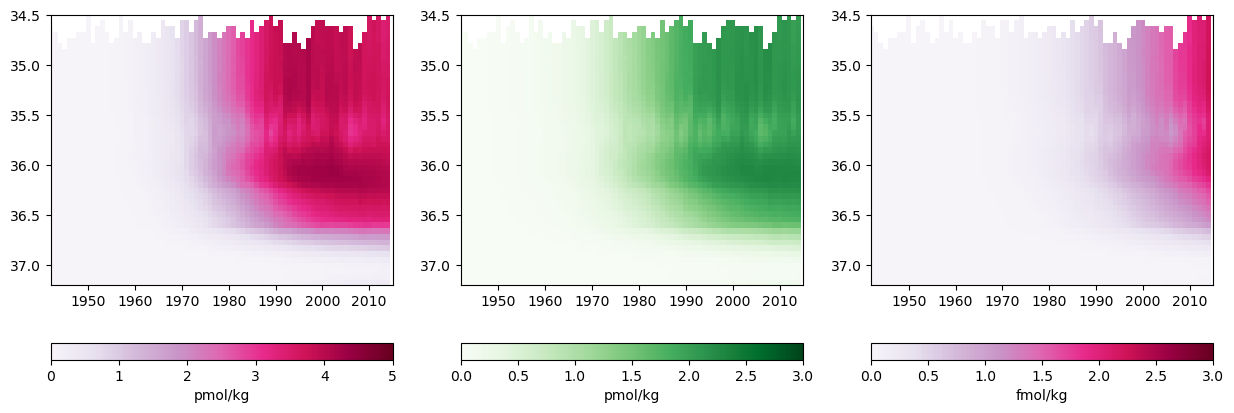

In [53]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

cm = ax[0].pcolormesh(section_dsm.year, weighted_mean_ds.sigma2, weighted_mean_ds.cfc11.T * variable_kwargs["cfc11"]["conversion"], 
               cmap = variable_kwargs["cfc11"]["cmap"], vmin = 0, vmax = 5)
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", label = "pmol/kg")

cm = ax[1].pcolormesh(section_dsm.year, weighted_mean_ds.sigma2, weighted_mean_ds.cfc12.T * variable_kwargs["cfc12"]["conversion"], 
               cmap = variable_kwargs["cfc12"]["cmap"], vmin = 0, vmax = 3)
fig.colorbar(cm, ax = ax[1], orientation = "horizontal", label = "pmol/kg")

cm = ax[2].pcolormesh(section_dsm.year, weighted_mean_ds.sigma2, weighted_mean_ds.sf6.T * variable_kwargs["sf6"]["conversion"], 
               cmap = variable_kwargs["sf6"]["cmap"], vmin = 0, vmax = 3)
fig.colorbar(cm, ax = ax[2], orientation = "horizontal", label = "fmol/kg")


[a.set_ylim(34.5, 37.2) for a in ax]
[a.set_xlim(1942, 2015) for a in ax]
[a.invert_yaxis() for a in ax]


Text(0.5, 1.0, 'log(Thickness)')

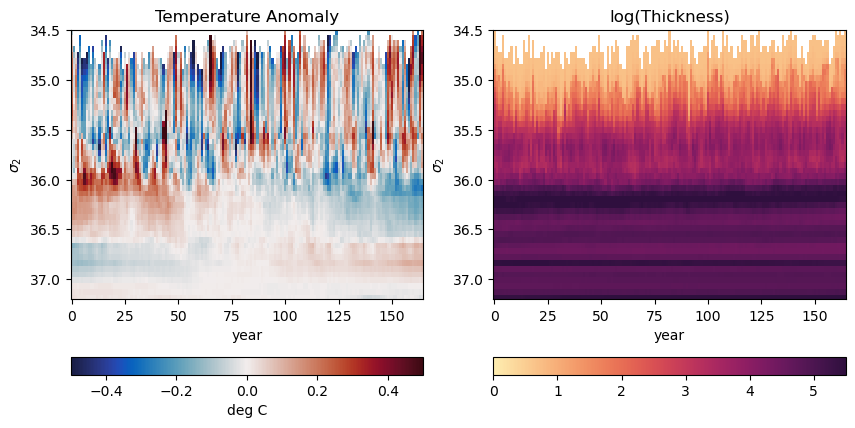

In [55]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

cm = ax[0].pcolormesh(weighted_mean_ds.year, weighted_mean_ds.sigma2, (weighted_mean_ds.thetao - weighted_mean_ds.thetao.mean("year")).T, 
               cmap = cmocean.cm.balance, vmin = -0.5, vmax = 0.5)
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", label = "deg C")
cm = ax[1].pcolormesh(weighted_mean_ds.year, weighted_mean_ds.sigma2,  np.log(weighted_mean_ds.thkcello).T, 
               cmap = cmocean.cm.matter, vmin = 0, vmax = 5.5)
fig.colorbar(cm, ax = ax[1], orientation = "horizontal", label = "")

[a.set_ylim(34.5, 37.2) for a in ax]
# [a.set_xlim(1942, 2015) for a in ax]
[a.invert_yaxis() for a in ax]
ax[0].set_ylabel(r"$\sigma_2$")
ax[1].set_ylabel(r"$\sigma_2$")
ax[0].set_xlabel("year")
ax[1].set_xlabel("year")
ax[0].set_title("Temperature Anomaly")
ax[1].set_title("log(Thickness)")


Text(0, 0.5, 'meters')

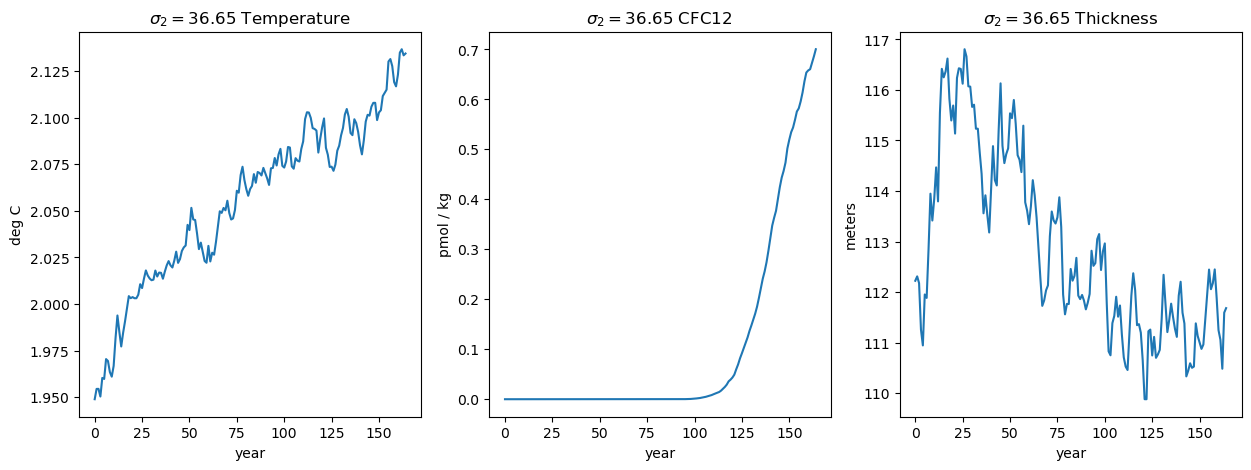

In [58]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

weighted_mean_ds.sel(sigma2 = 36.75, method = "nearest").thetao.plot(ax = ax[0]); ax[0].set_title(r"$\sigma_2 = 36.65$" + " Temperature")
cfc = weighted_mean_ds.sel(sigma2 = 36.75, method = "nearest").cfc12
cfc = cfc* variable_kwargs["cfc12"]["conversion"]
cfc.plot(ax = ax[1]); ax[1].set_title(r"$\sigma_2 = 36.65$" + " CFC12 ")
weighted_mean_ds.sel(sigma2 = 36.75, method = "nearest").thkcello.plot(ax = ax[2]); ax[2].set_title(r"$\sigma_2 = 36.65$" + " Thickness")

ax[0].set_ylabel("deg C")
ax[1].set_ylabel("pmol / kg")
ax[2].set_ylabel("meters")                                                                                                

[(50.0, 170.0), (50.0, 170.0), (50.0, 170.0)]

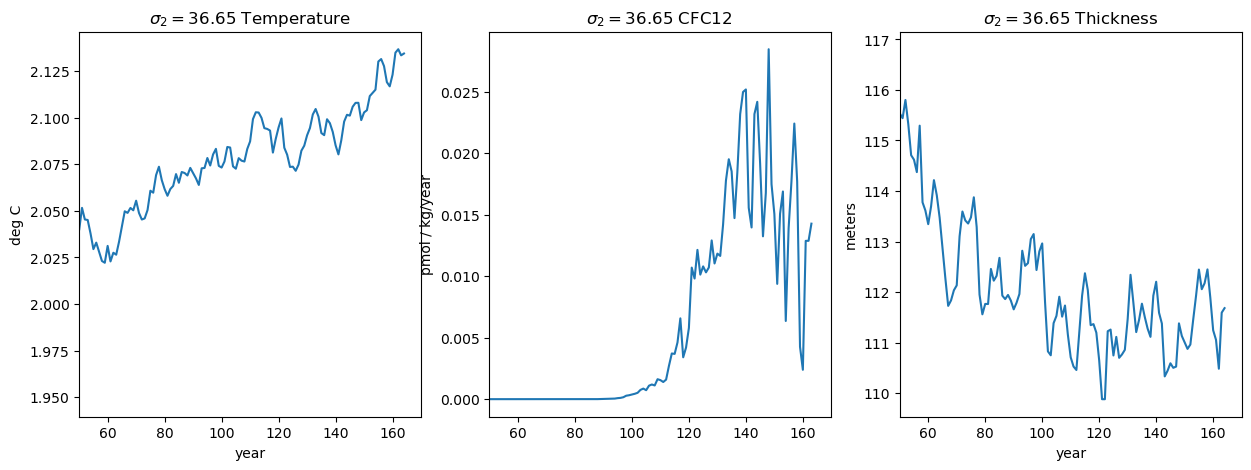

In [66]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

weighted_mean_ds.sel(sigma2 = 36.75, method = "nearest").thetao.plot(ax = ax[0]); ax[0].set_title(r"$\sigma_2 = 36.65$" + " Temperature")
cfc = weighted_mean_ds.sel(sigma2 = 36.75, method = "nearest").cfc12
cfc = cfc* variable_kwargs["cfc12"]["conversion"]
ax[1].plot(cfc.values[1:] - cfc.values[:-1])
ax[1].set_title(r"$\sigma_2 = 36.65$" + " CFC12 ")
weighted_mean_ds.sel(sigma2 = 36.75, method = "nearest").thkcello.plot(ax = ax[2]); ax[2].set_title(r"$\sigma_2 = 36.65$" + " Thickness")

ax[0].set_ylabel("deg C")
ax[1].set_ylabel("pmol / kg/year")
ax[2].set_ylabel("meters")   
[a.set_xlim(50, 170) for a in ax]
